## 1.Import Libraries

In [1]:
pip install folium

     |████████████████████████████████| 94 kB 4.9 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [15]:
conda install -c conda-forge dask-xgboost

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - rapidsai/linux-64::rapids==21.06.01=cuda11.0_py37_gecaf371_431
  - rapidsai/linux-64::py-xgboost==1.4.2dev.rapidsai21.06=cuda11.0py37_0
  - rapidsai/linux-64::cudf==21.06.01=cuda_11.0_py37_g101fc0fda4_2
  - rapidsai/linux-64::ucx==1.9.0+gcd9efd3=cuda11.0_0
  - rapidsai/noarch::cusignal==21.06.00=py38_ga78207b_0
  - rapidsai/linux-64::cudf_kafka==21.06.01=py37_g101fc0fda4_2
  - conda-forge/linux-64::libfaiss==1.7.0=cuda110h8045045_8_cuda
  - rapidsai/linux-64::libcugraph==21.06.00=cuda11.0_gf9ffd2de_0
  - rapidsai/linux-64::xgboost==1.4.2dev.rapidsai21.06=cuda11.0py37_0
  - rapidsai/linux-64::rapids-xg

In [16]:
# importing

import math
import numpy as np
import pandas as pd
import seaborn as sns # Library for statistics
import matplotlib.pyplot as plt
import dask.dataframe as dd
import folium
from folium.plugins import HeatMapWithTime
from math import * # Acces of all method of the module
import xgboost as xgb
import dask_xgboost as dxgb
from sklearn.metrics import mean_squared_error

palette = sns.color_palette('Paired',10)

import os
#os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'


from dask.distributed import Client

## 2.Start Dask Cluster
Connect to the existing DASK Cluster.

In [3]:
client = Client('141.79.146.1:8786') #set client to connect to Master Node

In [4]:
client #show Cluster

Client Scheduler: tcp://141.79.146.1:8786 Dashboard: http://141.79.146.1:8787/status,Cluster Workers: 15 Cores: 120 Memory: 233.52 GiB


## 3.Data Analyse

In [5]:
# We see what the data looks like
# Blocksize : we breack up the large file 

data = dd.read_csv('Data/train.csv', blocksize = "512MB")
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=12,,,,,,,,
,object,float64,object,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [6]:
#data = client.persist(data)

**As we can see above, some data have the type "object", we will convert this type into str to be use later for our model.**

In [10]:
# Lets some analyse to see range of data
data.describe().compute()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399200e+01,4.073514e+01,-7.399134e+01,4.073418e+01,1.000000e+00
50%,8.500000e+00,-7.398174e+01,4.075278e+01,-7.398007e+01,4.075329e+01,1.000000e+00
75%,1.250000e+01,-7.396692e+01,4.076732e+01,-7.396352e+01,4.076823e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


As we can see, some outliers are present in our train data: 
- fare_amount column has a min value of **-300 dollars** min and the max value of **93963 dollars** which makes no sense
- The passenger count has a max of **208 passengers** which makes no sense so wee will limit this to 6 passengers 

In [11]:
#data = data[data.passenger_count < 8]
#data = data[data.passenger_count > 0]

In [12]:
# We change the datatype
#data['key'] = dd.to_datetime(data['key'])
#data['pickup_datetime'] = dd.to_datetime(data['pickup_datetime'])

**Fare amount** is the data to predict. So we do some analysis on this data first.

In [13]:
#data = data[data.fare_amount > 0 ]

In [13]:
def plot_density(series = data["fare_amount"].compute(),title = "Fare Distribution"):
    sns.histplot(series,kde = True , stat = 'density', discrete = True)
    sns.despine()
    plt.title(title)
    plt.show()

KeyboardInterrupt: 

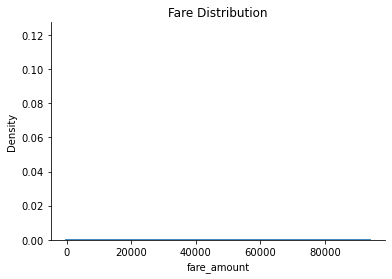

In [15]:
plot_density()

In [16]:
# We remove no sense values
data = data[data.fare_amount.between(0,100)]

In [17]:
# We keep in the memory data
data = data.persist()

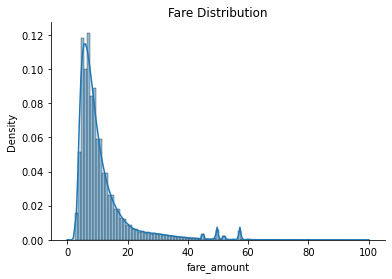

CPU times: user 2min 36s, sys: 10.7 s, total: 2min 47s
Wall time: 6min 56s


In [18]:
%%time
plot_density(data.fare_amount.compute())

**Now let's have a look at the Passenger_count data:**

In [ ]:
# We create a dataset basically groupping by the number of passenger
#df_passengerGroup = df.groupby('passenger_count')

In [9]:
 passengerCount = data['passenger_count'].value_counts().compute()

<AxesSubplot:ylabel='passenger_count'>

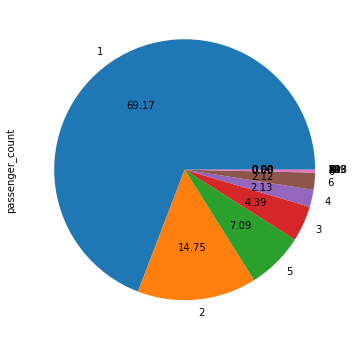

In [12]:
#passengerCount.plot.pie(autopct = "%.2f",figsize = (6,6))

<AxesSubplot:title={'center':'Passenger Count'}>

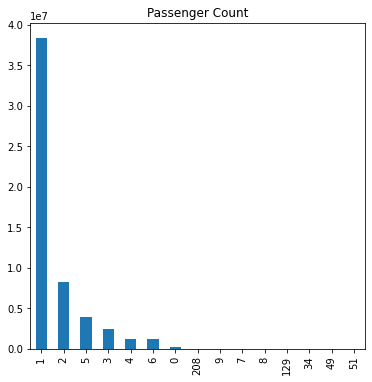

In [14]:
plt.title("Passenger Count")

passengerCount.plot.bar(figsize = (6,6))

In [ ]:
# We release the variable
del passengerCount

As we can see on the bar chart above, several value make no sense. In the cleaning data Train step, we will reduce the number of passenger to 7 max.

**Let's have a look at *pickup_datetime* data.**
For that, we have to extract the differents data like Year, Month, Day, Hour and Min.

In [6]:
# To use the date relative data such as Year, month ..., we use the .to datetime function
data.index = dd.to_datetime(data["pickup_datetime"])
data["dow"] = data.index.dt.weekday
data["month"] = data.index.dt.month
data["year"] = data.index.dt.year
data["hour"] = data.index.dt.hour
data["minute"] = data.index.dt.minute
data["weekdayName"] = data.index.dt.day_name()

In [8]:
# Let's have a look to check the new columns added
data.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,month,year,hour,minute
2009-06-15 17:26:21+00:00,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,6,2009,17,26
2010-01-05 16:52:16+00:00,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,1,2010,16,52


In [8]:
dataValueCount = data['hour'].value_counts().compute()

Text(0.5, 0, 'hour')

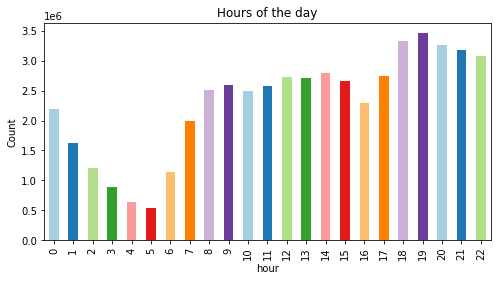

In [15]:
sequenceHour = list(range(0,23))
dataValueCount.loc[sequenceHour].plot.bar(figsize = (8,4), color = palette)
plt.title("Hours of the day")
plt.ylabel("Count")
plt.xlabel("hour")

It can be interessant to have a look on the ***fare_amount*** according to the time of the day :

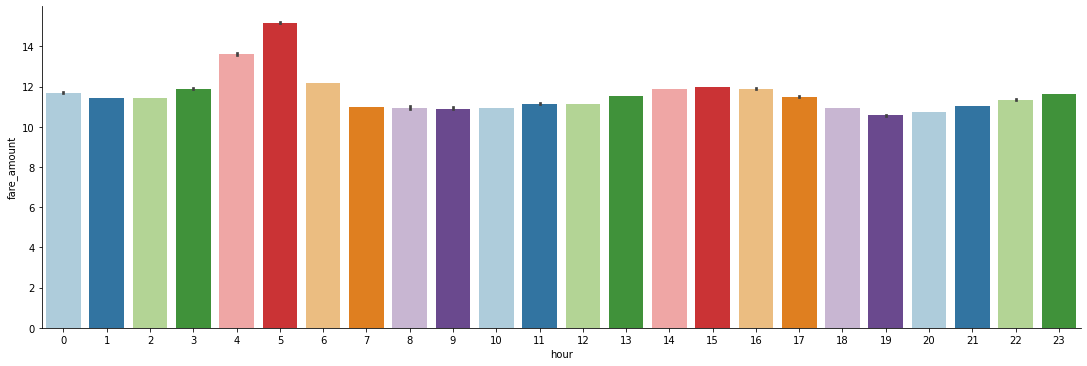

In [6]:
sns.catplot(x = "hour", y = "fare_amount", palette = palette, data = data[['fare_amount','hour']].compute(), kind = "bar",height = 5, aspect = 3)
sns.despine()
plt.show()

We can also take a closer look at ***fare_amount*** by ***day of week***: 

In [6]:
data.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,month,year,hour,minute,weekdayName
2009-06-15 17:26:21+00:00,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,6,2009,17,26,Monday
2010-01-05 16:52:16+00:00,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,1,2010,16,52,Tuesday


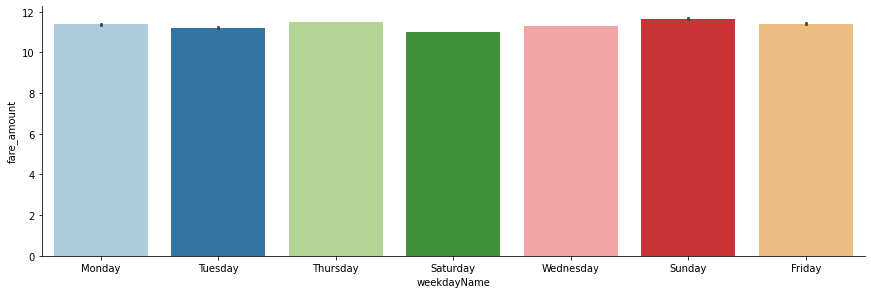

In [7]:
sns.catplot(x = "weekdayName", y = "fare_amount" ,palette = palette, data = data[['fare_amount','weekdayName']].compute(), kind = "bar",height = 4, aspect = 3)
sns.despine()
plt.show()

Now let's have a look at ***Geospatial*** Features:

For that, we will use the GPS Coordinates. To avoid no sense values though we will make sure that pickup and dropoff don't get same coordinates.
We set the coodinate boundaries from a boundaries-Box Tools online : https://boundingbox.klokantech.com

In [8]:
# Set Boundaries of New York in Decimal Degree (MIN,MAX)
nycBOX = (-74.25909, 40.477399, -73.700181, 40.916178)

In [9]:
data = data[(data["pickup_latitude"] > nycBOX[1]) & (data["pickup_latitude"] <= nycBOX[3])]
data = data[(data["pickup_longitude"] > nycBOX[0]) & (data["pickup_longitude"] <= nycBOX[2])]
data = data[(data["dropoff_latitude"] > nycBOX[1]) & (data["dropoff_latitude"] <= nycBOX[3])]
data = data[(data["dropoff_longitude"] > nycBOX[0]) & (data["dropoff_longitude"] <= nycBOX[2])]

In [16]:
data["pickup_latitude"].compute().min()

40.477508

In [9]:
# We find the center location of NY on this website : latitude.to
center_location = [40.7166638, -74]

In [13]:
dataForMAp= data.head(10000)

In [17]:
# We add latitudes and longitudes in a list which is ordered by date
date_list = []
for hour in dataForMAp["hour"].sort_values().unique():
    date_list.append(dataForMAp.loc[dataForMAp.hour == hour, ['pickup_latitude', 'pickup_longitude']].values.tolist())

In [26]:
# We plot the HeatMapWithTime


m = folium.Map(location = center_location, control_scale = True, zoom_start = 11)
HeatMapWithTime(date_list, radius = 5, gradient = {0.2: 'blue', 0.4: 'lime', 0.6:'orange', 1:'red'}, min_opacity = 0.5, max_opacity = 0.8, use_local_extrema = True).add_to(m)
m

As we can see on the map above, pickups are mainly concentrate in the city center and at airports.

Now let's have look about ***Distance*** features:
For that, we will calculate the distance between Pickups and Dropoff with the Haversine Formula.
Link to Haversine Formula : https://en.wikipedia.org/wiki/Haversine_formula*

In [39]:
def distance_haversine(lat1, lon1, lat2, lon2):
    
    R = 6372.8 # Radius of Earth in kilometers (km)
    
    # convert decimals angles degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    return round((R * c), 2)

In [40]:
# Test Function :
print(distance_haversine(40.721319,-73.844311,40.712278,-73.841610),"Km")

1.03 Km


distance_haversine function give the same result as an calculate distance website (https://www.movable-type.co.uk/scripts/latlong.html)

In [10]:
def distance_haversine_array(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    
    R = 6372.8 # Radius of Earth in kilometers (km)
    
    # We use Np. to make operation in the entire column
    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distance_haversine_array = R * c
    
    return distance_haversine_array

In [11]:
data["distance"] = distance_haversine_array(data,start_lat="pickup_latitude", start_lon="pickup_longitude",end_lat="dropoff_latitude", end_lon="dropoff_longitude")

In [32]:
data["distance"].describe().compute()

count    5.418685e+07
mean     3.305313e+00
std      3.550740e+00
min      0.000000e+00
25%      1.254957e+00
50%      2.153572e+00
75%      3.911124e+00
max      4.617531e+01
Name: distance, dtype: float64

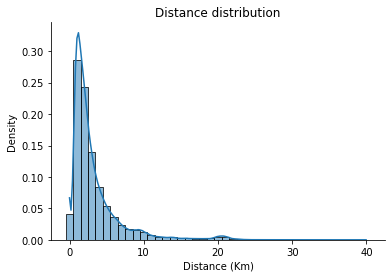

In [16]:
sns.histplot(data[data.distance < 40].distance,kde = True , stat = 'density', discrete = True)
sns.despine()
plt.xlabel("Distance (Km)")
plt.title("Distance distribution")
plt.show()

## 3.Training

In [6]:
train_data = dd.read_csv('Data/train.csv', blocksize = "512MB")

### 3.1 Cleaning Data

In [10]:
def clean_Data(data):
    data = data.drop(["key"], axis = 1)
    data = data[(data.dropoff_latitude != 0) | (data.dropoff_longitude != 0)]
    data = data[(data.pickup_latitude != 0) | (data.pickup_longitude != 0)]
    
    #if "fare_amount" in list(data):
    data = data[data.fare_amount.between(0, 4000)]
    data = data[data.passenger_count < 7]
    data = data[data.passenger_count >= 0]
    data = data[(data["pickup_latitude"] > nycBOX[1]) & (data["pickup_latitude"] <= nycBOX[3])]
    data = data[(data["pickup_longitude"] > nycBOX[0]) & (data["pickup_longitude"] <= nycBOX[2])]
    data = data[(data["dropoff_latitude"] > nycBOX[1]) & (data["dropoff_latitude"] <= nycBOX[3])]
    data = data[(data["dropoff_longitude"] > nycBOX[0]) & (data["dropoff_longitude"] <= nycBOX[2])]
    return data

train_data = clean_Data(train_data)


In [17]:
train_data.index = dd.to_datetime(train_data["pickup_datetime"])
train_data["dow"] = train_data.index.dt.weekday
train_data["month"] = train_data.index.dt.month
train_data["year"] = train_data.index.dt.year
train_data["hour"] = train_data.index.dt.hour
train_data["minute"] = train_data.index.dt.minute
train_data["weekdayName"] = train_data.index.dt.day_name()

In [18]:
X, y = train_data.drop('fare_amount', axis = 1), train_data['fare_amount']
X_train, X_validation = X.random_split([0.7, 0.3], random_state = 0)
y_train, y_validation = y.random_split([0.7, 0.3], random_state = 0)